## Overview

In this final notebook, the cleaned and processed subreddit posts from notebook 2 were used to train a model made up of a vectoriser and a classifier. The trained model was then used to derive a list of words which had a higher likelihood of predicting which subreddit a post belonged to. The notebook concluded with a discussion on the results, limitations and possible future directions for this project. Accuracy was used as the primary criteria to evaluate and find the best model in this project, as there is no particular need in our context to optimise a particular classification metric. 

The following steps were carried out on the earlier processed subreddit posts:

1. Split data into training and test sets
2. Establish null model, using the proportion of the majority subreddit as the baseline accuracy
3. Set up modeling pipe
* A total of four modeling pipes were set up, with each pipe made up of 1 vectoriser and 1 classifier. The four pipes come from a permutation of 2 vectorisers and 2 classifiers.
* The two vectorisers used are: i) CountVectorizer and ii) Term Frequency–Inverse Document Frequency (TF-IDF) Vectorizer
* The two classifiers used are: i) Multinomial Naive Bayes and ii) Logistic Regression
4. Optimise the hyperparameters, train and score the models using GridSearchCV
5. Find the GridSearchCV best score, train and test score, and other classification metrics for each modeling pipe.
6. Select the model with the best accuracy, based on the test score.
7. Find the top 10 words which had a higher likelihood to predict which subreddit a post came from, r/tea or r/Coffee

Our final chosen model was a combination of **TF-IDF vectoriser and Multinomial Naive Bayes classifier**, with an **accuracy of 0.93**.

## Import Python modules

In [45]:
import pandas as pd
import numpy as np
import time
import string
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display_html

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score, roc_curve

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400

## Import dataset from earlier notebook

In [3]:
df_merged = pd.read_csv('data/merged.csv')

print(f" Shape of imported data: {df_merged.shape}")

 Shape of imported data: (1578, 19)


In [4]:
#checking looks of imported data
df_merged.head(3)

,Unnamed: 0,subreddit,title,selftext,alltext,title_cleaned,selftext_cleaned,alltext_cleaned,title_word_count,selftext_word_count,title_token,selftext_token,alltext_token,title_sw,selftext_sw,alltext_sw,title_lem,selftext_lem,alltext_lem
0,0,1,"What's in your cup? Daily discussion, questions and stories - May 23, 2022","What are you drinking today? What questions have been on your mind? Any stories to share? And don't worry, no one will make fun of you for what you drink or the questions you ask. \n\nYou can also talk about anything else on your mind, from your specific routine while making tea, or how you've been on an oolong kick lately. Feel free to link to pictures in here, as well. You can even talk ...","What's in your cup? Daily discussion, questions and stories - May 23, 2022 What are you drinking today? What questions have been on your mind? Any stories to share? And don't worry, no one will make fun of you for what you drink or the questions you ask. \n\nYou can also talk about anything else on your mind, from your specific routine while making tea, or how you've been on an oolong kick ...",what s in your cup daily discussion questions and stories may,what are you drinking today what questions have been on your mind any stories to share and don t worry no one will make fun of you for what you drink or the questions you ask \n\nyou can also talk about anything else on your mind from your specific routine while making tea or how you ve been on an oolong kick lately feel free to link to pictures in here as well you can even talk ...,what s in your cup daily discussion questions and stories may what are you drinking today what questions have been on your mind any stories to share and don t worry no one will make fun of you for what you drink or the questions you ask \n\nyou can also talk about anything else on your mind from your specific routine while making tea or how you ve been on an oolong kick ...,24,115,"['what', 's', 'in', 'your', 'cup', 'daily', 'discussion', 'questions', 'and', 'stories', 'may']","['what', 'are', 'you', 'drinking', 'today', 'what', 'questions', 'have', 'been', 'on', 'your', 'mind', 'any', 'stories', 'to', 'share', 'and', 'don', 't', 'worry', 'no', 'one', 'will', 'make', 'fun', 'of', 'you', 'for', 'what', 'you', 'drink', 'or', 'the', 'questions', 'you', 'ask', 'you', 'can', 'also', 'talk', 'about', 'anything', 'else', 'on', 'your', 'mind', 'from', 'your', 'specific', 'ro...","['what', 's', 'in', 'your', 'cup', 'daily', 'discussion', 'questions', 'and', 'stories', 'may', 'what', 'are', 'you', 'drinking', 'today', 'what', 'questions', 'have', 'been', 'on', 'your', 'mind', 'any', 'stories', 'to', 'share', 'and', 'don', 't', 'worry', 'no', 'one', 'will', 'make', 'fun', 'of', 'you', 'for', 'what', 'you', 'drink', 'or', 'the', 'questions', 'you', 'ask', 'you', 'can', 'al...","['cup', 'daily', 'discussion', 'questions', 'stories', 'may']","['drinking', 'today', 'questions', 'mind', 'stories', 'share', 'worry', 'one', 'fun', 'questions', 'ask', 'also', 'talk', 'anything', 'else', 'mind', 'specific', 'routine', 'making', 'oolong', 'kick', 'lately', 'feel', 'free', 'link', 'pictures', 'well', 'even', 'talk', 'non', 'related', 'topics', 'maybe', 'advice', 'guy', 'gal', 'talk', 'life', 'general']","['cup', 'daily', 'discussion', 'questions', 'stories', 'may', 'drinking', 'today', 'questions', 'mind', 'stories', 'share', 'worry', 'one', 'fun', 'questions', 'ask', 'also', 'talk', 'anything', 'else', 'mind', 'specific', 'routine', 'making', 'oolong', 'kick', 'lately', 'feel', 'free', 'link', 'pictures', 'well', 'even', 'talk', 'non', 'related', 'topics', 'maybe', 'advice', 'guy', 'gal', 'ta...","['cup', 'daily', 'discussion', 'question', 'story', 'may']","['drinking', 'today', 'question', 'mind', 'story', 'share', 'worry', 'one', 'fun', 'question', 'ask', 'also', 'talk', 'anything', 'else', 'mind', 'specific', 'routine', 'making', 'oolong', 'kick', 'lately', 'feel', 'free', 'link', 'picture', 'well', 'even', 't

#### Select and rename columns

In [5]:
df = df_merged[['subreddit','alltext_lem']]
df.rename(columns = {'alltext_lem': 'text'}, inplace = True)

print(f"Check column names: {df.columns.tolist()}")
df.head(3)

Check column names: ['subreddit', 'text']


C:\Users\yongl\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,subreddit,text
0,1,"['cup', 'daily', 'discussion', 'question', 'story', 'may', 'drinking', 'today', 'question', 'mind', 'story', 'share', 'worry', 'one', 'fun', 'question', 'ask', 'also', 'talk', 'anything', 'else', 'mind', 'specific', 'routine', 'making', 'oolong', 'kick', 'lately', 'feel', 'free', 'link', 'picture', 'well', 'even', 'talk', 'non', 'related', 'topic', 'maybe', 'advice', 'guy', 'gal', 'talk', 'lif..."
1,1,"['marketing', 'monday', 'may', 'realize', 'lot', 'people', 'involved', 'industry', 'thread', 'weekly', 'feature', 'anyone', 'promote', 'current', 'project', 'without', 'worrying', 'self', 'promotion', 'rule', 'feel', 'free', 'include', 'link', 'shop', 'crowdfunding', 'site', 'survey', 'sale', 'discount', 'code', 'rule', 'claim', 'health', 'benefit', 'remains', 'effect', 'go', 'without', 'sayin..."
2,1,"['i’m', 'london', 'thank', 'recommendation']"


## Split data into training and testing dataset

In [6]:
# Define training and testing sets.
X = df['text']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

## Null model

In [7]:
# Check proportion of tea and coffee posts
print(f"Proportion of tea posts: {y.value_counts(normalize = True)[1]}")
print(f"Proportion of coffee posts: {y.value_counts(normalize = True)[0]}")

Proportion of tea posts: 0.6020278833967047
Proportion of coffee posts: 0.3979721166032953


Our null model to classify which subreddit a new reddit post comes from, is based on the subreddit where the majority of posts come from. As there are more posts from 'tea', our null model predicts that there will be a 60% chance that a new post will come from the 'tea' subreddit.

In [8]:
print(f'baseline accuracy: {y.value_counts(normalize = True)[1]}')

baseline accuracy: 0.6020278833967047


## Setting up modeling pipelines

1. We will be testing vectorizer-model combinations using the following: 
* 2 vectorizers - CountVectorizer and Term Frequency-Inverse Document Frequency (TF-IDF); and 
* 2 models - Multinomial Naive Bayes and Logistic Regression

2. Hence we will be setting up 4 pipelines in total, with permutations of the 2 vectorizers and 2 models:
* pipe_cm: CountVectorizer and Multinomial Naive Bayes
* pipe_cl: CountVectorizer and Logistic Regression
* pipe_tm: TF-IDF and Multinomial Naive Bayes
* pipe_tl: TF-IDF and Logistic Regression

In [9]:
#setting up 4 pipelines

pipe_cm = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_cl = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe_tm = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_tl = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])


## Modeling with GridSearchCV

#### Create modeling functions (try to add a params = None)

In [81]:
#create function for GridSearchCV for CrossVectorizer pipelines 
def gs_cv(pipe, name):
    
    #setting up initial pipe parameters
    pipe_cv_params = {
    'cvec__max_features': [1_000, 2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]}
        
    pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]}

    if name in ['pipe_cm','pipe_cl']:
        pipe_params = pipe_cv_params
    elif name in ['pipe_tm', 'pipe_tl']:
        pipe_params = pipe_tvec_params

    # Instantiate GridSearchCV.
    gs = GridSearchCV(pipe, # pipe that we are optimizing
                      param_grid=pipe_params, # parameters values are we searching
                      cv=5,
                     n_jobs = -1) # 5-fold cross-validation.
    
    # Fit GridSearch to training data.
    gs.fit(X_train, y_train)
    
    return gs

def scoring(gs, name):
    
    results = []
    # Best score
    best_score = gs.best_score_
    results.append(best_score)
    #print(f"Best score for {name}: {best_score}\n")
    
    # Score model on training set.
    training_score = gs.score(X_train, y_train)
    results.append(training_score)
    #print(f"Score on training set for {name}: {training_score}\n")
    
    # Score model on testing set.
    test_score = gs.score(X_test, y_test)
    results.append(test_score)
    #print(f"Score on test set for {name}: {gs.score(X_test, y_test)}\n")
    
    #Calculate ROC AUC score.
    #auc = roc_auc_score(y_test, gs.predict_proba(X_test)[:,1])
    #results.append(auc)
    
    return pd.DataFrame({name : results}, index = ['best score', 'training score', 'test score'])#, 'ROC AUC'])
    
#construct function for top keywords, coefficients and impact
def keywords(gs): 
    #construct dataframe of word and coefficients
    #access name within pipeline: gs.best_estimator_[0].get_feature_names()
    #access coefficients from within pipeline: gs.best_estimator_[1].coef_ OR gs.best_estimator_.named_steps.lr.coef_
    word_coef = pd.DataFrame({'word': (gs.best_estimator_[0].get_feature_names()),'coef': gs.best_estimator_[1].coef_.T.tolist()})

    #create impact column
    word_coef['impact'] = word_coef['coef'].apply(lambda x: np.exp(x)[0])

    #word_coef.head()
    
    #find top 20 keywords for tea
    tea_word_impact = word_coef.sort_values(by = 'impact', ascending = False).head(20)[['word', 'impact']]

    #find top 20 keywords for coffee
    coffee_word_impact = word_coef.sort_values(by = 'impact', ascending = True).head(20)[['word', 'impact']]
    
    return tea_word_impact, coffee_word_impact    

#feature importance for multinomial NF models
def FeaturesImportanceNB(trfmr, nb):
    df = pd.DataFrame()

    df['feature'] = trfmr.get_feature_names()
    df['log prob diff'] = nb.feature_log_prob_[1,:] - nb.feature_log_prob_[0, :]

    df_tea = df.sort_values(by= 'log prob diff', ascending= True).head(10)
    df_coffee = df.sort_values(by= 'log prob diff', ascending= False).head(10)

    #caption1 = df_tea.style.set_table_attributes("style='display:inline'").set_caption('Coffee Features Importance')
    #caption2 = df_coffee.style.set_table_attributes("style='display:inline'").set_caption('Tea Features Importance')
    #display_html(caption1._repr_html_()+'&emsp;&emsp;'+caption2._repr_html_(), raw=True)

### Model 1: CountVectorizer and Multinomial Naive Bayes

#### Optimise GridSearchCV parameters and train model

In [83]:
%%time
#pipe_cm: CountVectorizer and Multinomial Naive Bayes
gs_m1 = gs_cv(pipe_cm, 'pipe_cm')
print(f"Best params: {gs_m1.best_params_}\n")
pipe_cm_results = scoring(gs_m1, 'pipe_cm')

pipe_cm_results

Best params: {'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2)}

Wall time: 4.46 s


,pipe_cm
best score,0.928110
training score,0.964995
test score,0.927063


#### Plot confusion matrix 

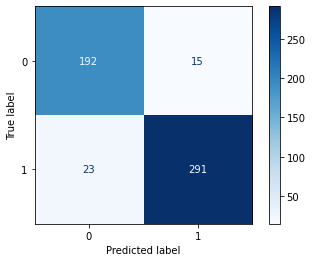

In [14]:
#pipe_cm: CountVectorizer and Multinomial Naive Bayes
# Get predictions
preds_cvec = gs_m1.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_cvec).ravel()
# visualize this
plot_confusion_matrix(gs_m1, X_test, y_test, cmap='Blues', values_format='d');

#### Calculate classification metrics

In [55]:
#confusion matrix results and classification metrics
#print(confusion_matrix(y_test, preds_cvec))
print(classification_report(y_test, preds_cvec))
#print(f"Best params: {gs.best_params_}\n")
#print(f"Coefficients: {gs_m1.best_estimator_.named_steps.nb.coef_}\n")
print(f"ROC AUC score: {roc_auc_score(y_test, gs_m1.predict_proba(X_test)[:,1])}")

              precision    recall  f1-score   support

           0       0.91      0.82      0.86       207
           1       0.89      0.95      0.92       314

    accuracy                           0.90       521
   macro avg       0.90      0.88      0.89       521
weighted avg       0.90      0.90      0.90       521

ROC AUC score: 0.9663528108557186


#### Find top predictor keywords for each subreddit

In [60]:
#find predictor words and their impact
nb_m1 = gs_m1.best_estimator_.named_steps['nb']
cvec_m1 = gs_m1.best_estimator_.named_steps['cvec']
FeaturesImportanceNB(cvec_m1, nb_m1)

df = pd.DataFrame()

df['feature'] = tvec_m3.get_feature_names()
df['log prob diff'] = nb_m3.feature_log_prob_[1,:] - nb_m3.feature_log_prob_[0, :]

df_tea = df.sort_values(by= 'log prob diff', ascending= False).head(10)
df_coffee = df.sort_values(by= 'log prob diff', ascending= True).head(10)

In [61]:
#top keywords for tea
df_tea.head(10)

,feature,log prob diff
2694,oolong,2.851576
4204,teapot,2.590760
2330,leaf,2.568318
2467,matcha,2.236945
2405,loose,2.153259
3540,sencha,2.098678
1955,green,1.963594
570,chai,1.963325
4820,white,1.945128
666,collection,1.768956


In [62]:
#top keywords for coffee
df_coffee.head(10)

,feature,log prob diff
320,bean,-2.569945
1959,grind,-2.484708
1961,grinder,-2.465721
2431,machine,-2.429283
1478,espresso,-2.376187
3357,roast,-2.250142
60,aeropress,-2.052606
3359,roaster,-1.995707
1603,extraction,-1.904075
2933,press,-1.897221


## Model 2: CountVectorizer and Logistic Regression

#### Optimising GridSearch CV parameters and train model

In [84]:
%%time
#pipe_cl: CountVectorizer and Logistic Regression

gs_m2 = gs_cv(pipe_cl, 'pipe_cl')
print(gs_m2.best_params_)
pipe_cl_results = scoring(gs_m2, 'pipe_cl')
pipe_cl_results

{'cvec__max_df': 0.9, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}
Wall time: 2.5 s


,pipe_cl
best score,0.921497
training score,0.992431
test score,0.896353


#### Plot confusion matrix

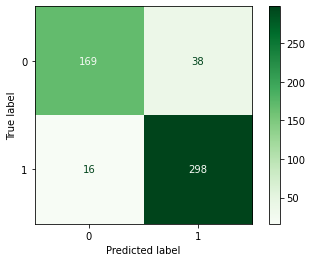

In [64]:
#pipe_cl: CountVectorizer and Logistic Regression
# Get predictions
preds_cvec = gs_m2.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_cvec).ravel()
# visualize this
plot_confusion_matrix(gs_m2, X_test, y_test, cmap='Greens', values_format='d');

#### Calculate classification metrics

In [65]:
#confusion matrix results and classification metrics
#print(confusion_matrix(y_test, preds_cvec))
print(classification_report(y_test, preds_cvec))
#print(f"Best params: {gs.best_params_}\n")
#print(f"Coefficients: {gs.best_estimator_.named_steps.lr.coef_}\n")
print(f"ROC AUC score: {roc_auc_score(y_test, gs_m2.predict_proba(X_test)[:,1])}")

              precision    recall  f1-score   support

           0       0.91      0.82      0.86       207
           1       0.89      0.95      0.92       314

    accuracy                           0.90       521
   macro avg       0.90      0.88      0.89       521
weighted avg       0.90      0.90      0.90       521

ROC AUC score: 0.9595833717960552


#### Find top predictor keywords for each subreddit

In [66]:
 #find predictor words and their impact
tea_word_impact,  coffee_word_impact = keywords(gs_m2)

In [67]:
#top keywords for tea
tea_word_impact

,word,impact
505,leaf,3.054599
886,teapot,2.905124
555,matcha,2.827130
84,black,2.810726
622,oolong,2.656410
391,green,2.184538
492,kettle,2.044830
537,loose,2.029692
466,infusion,2.000136
971,white,1.835554


In [68]:
#top keywords for coffee
coffee_word_impact

,word,impact
69,bean,0.167770
748,roaster,0.260309
746,roast,0.261143
274,espresso,0.274661
139,change,0.282754
394,grinder,0.289481
545,machine,0.300110
15,aeropress,0.332532
393,grind,0.337092
361,funnel,0.349473


## Model 3: TF-IDF and Multinomial Naive Bayes

#### Optimising GridSearch CV parameters and train model

In [85]:
%%time
#pipe_tm: TF-IDF and Multinomial Naive Bayes

gs_m3 = gs_cv(pipe_tm, 'pipe_tm')
print(gs_m3.best_params_)
pipe_tm_results = scoring(gs_m3, 'pipe_tm')
pipe_tm_results

{'tvec__max_features': 5000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}
Wall time: 964 ms


,pipe_tm
best score,0.934736
training score,0.992431
test score,0.930902


#### Plot confusion matrix

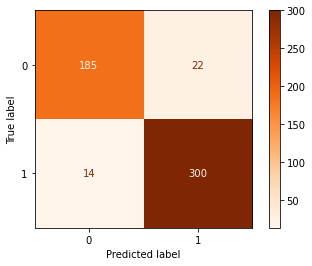

In [70]:
#pipe_tm: TF-IDF and Multinomial Naive Bayes
# Get predictions
preds_tvec = gs_m3.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()
# visualize this
plot_confusion_matrix(gs_m3, X_test, y_test, cmap='Oranges', values_format='d');

#### Calculate classification metrics

In [71]:
#confusion matrix results and classification metrics
#print(confusion_matrix(y_test, preds_tvec))
print(classification_report(y_test, preds_tvec))
#print(f"Best params: {gs.best_params_}\n")
#print(f"Coefficients: {gs.best_estimator_.named_steps.lr.coef_}\n")
print(f"ROC AUC score: {roc_auc_score(y_test, gs_m3.predict_proba(X_test)[:,1])}")

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       207
           1       0.93      0.96      0.94       314

    accuracy                           0.93       521
   macro avg       0.93      0.92      0.93       521
weighted avg       0.93      0.93      0.93       521

ROC AUC score: 0.9756915597402998


####  Find top predictor keywords for each subreddit

In [30]:
#find predictor words and their impact

nb_m3 = gs_m3.best_estimator_.named_steps['nb']
tvec_m3 = gs_m3.best_estimator_.named_steps['tvec']
FeaturesImportanceNB(tvec_m3, nb_m3)

df = pd.DataFrame()

df['feature'] = tvec_m3.get_feature_names()
df['log prob diff'] = nb_m3.feature_log_prob_[1,:] - nb_m3.feature_log_prob_[0, :]

df_tea = df.sort_values(by= 'log prob diff', ascending= False).head(10)
df_coffee = df.sort_values(by= 'log prob diff', ascending= True).head(10)

In [31]:
df_tea.head(10)

,feature,log prob diff
2694,oolong,2.851576
4204,teapot,2.590760
2330,leaf,2.568318
2467,matcha,2.236945
2405,loose,2.153259
3540,sencha,2.098678
1955,green,1.963594
570,chai,1.963325
4820,white,1.945128
666,collection,1.768956


In [72]:
df_coffee.head(10)

,feature,log prob diff
320,bean,-2.569945
1959,grind,-2.484708
1961,grinder,-2.465721
2431,machine,-2.429283
1478,espresso,-2.376187
3357,roast,-2.250142
60,aeropress,-2.052606
3359,roaster,-1.995707
1603,extraction,-1.904075
2933,press,-1.897221


## Model 4: TF-IDF and Logistic Regression

#### Optimising GridSearch CV parameters

In [86]:
%%time
#pipe_tl: TF-IDF and Logistic Regression

gs_m4 = gs_cv(pipe_tl, 'pipe_tl')
print(gs_m4.best_params_)
pipe_tl_results = scoring(gs_m4, 'pipe_tl')
pipe_tl_results 

{'tvec__max_features': 3000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}
Wall time: 1.17 s


,pipe_tl
best score,0.913914
training score,0.955535
test score,0.909789


#### Plot confusion matrix

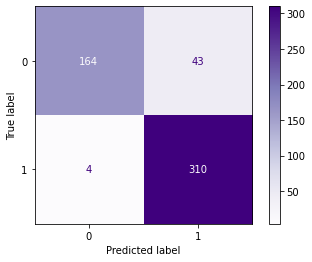

In [37]:
#pipe_tl: TF-IDF and Logistic Regression
# Get predictions
preds_tvec = gs_m4.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()
# visualize this
plot_confusion_matrix(gs_m4, X_test, y_test, cmap='Purples', values_format='d');

#### Calculate classification metrics

In [38]:
#print(confusion_matrix(y_test, preds_tvec))
print(classification_report(y_test, preds_tvec))
#print(f"Best params: {gs.best_params_}\n")
#print(f"Coefficients: {gs.best_estimator_.named_steps.lr.coef_}\n")
print(f"ROC AUC score: {roc_auc_score(y_test, gs_m4.predict_proba(X_test)[:,1])}")

[[164  43]
 [  4 310]]
              precision    recall  f1-score   support

           0       0.98      0.79      0.87       207
           1       0.88      0.99      0.93       314

    accuracy                           0.91       521
   macro avg       0.93      0.89      0.90       521
weighted avg       0.92      0.91      0.91       521

ROC AUC score: 0.9705837102680083


#### Find top predictor keywords for each subreddit

In [78]:
#find predictor words and their impact
tea_word_impact,  coffee_word_impact = keywords(gs_m4)

In [79]:
tea_word_impact

,word,impact
1494,leaf,7.300345
1842,oolong,5.767364
2593,teapot,5.573944
1142,green,4.841959
272,black,4.018031
1624,matcha,3.783588
1555,loose,3.535867
2879,white,3.302554
2303,sencha,2.904729
438,chai,2.540969


In [80]:
coffee_word_impact

,word,impact
209,bean,0.026130
1580,machine,0.082791
1157,grinder,0.106142
837,espresso,0.114002
1147,grind,0.117104
2209,roast,0.119866
1988,pour,0.152086
2215,roaster,0.173267
51,aeropress,0.191910
1171,ground,0.215013


## Results from modeling

### TF-IDF + Multinomial Naive Bayes chosen as best model

With the highest accuracy score (test score: 0.930902) amongst the four tested models,  **TF-IDF + Multinomial Naive Bayes** is our chosen combination to classify between tea and coffee subreddit posts. The training score is slightly higher than the test score, which indicates there is likely no overfitting. 

#### Accuracy scores

In [87]:
#combine results from all 4 pipes into one table
combined_results  = pd.concat([pipe_cm_results, pipe_cl_results, pipe_tm_results, pipe_tl_results], axis = 1) 

combined_results

,pipe_cm,pipe_cl,pipe_tm,pipe_tl
best score,0.928110,0.921497,0.934736,0.913914
training score,0.964995,0.992431,0.992431,0.955535
test score,0.927063,0.896353,0.930902,0.909789


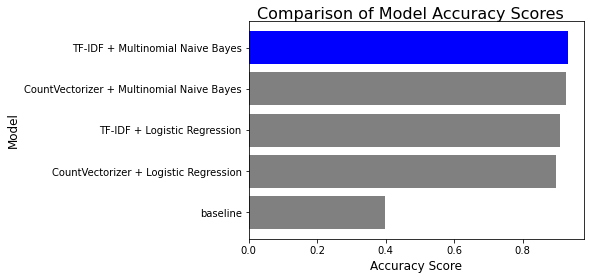

In [99]:
#visualising accuracy scores based on test score
base_score = y_test.value_counts(normalize=True)[0]
models_accuracy = pd.DataFrame()
models_accuracy['score'] = [0.930902,0.927063,0.909789,0.896353,base_score]
models_accuracy['model'] = ['TF-IDF + Multinomial Naive Bayes','CountVectorizer + Multinomial Naive Bayes','TF-IDF + Logistic Regression','CountVectorizer + Logistic Regression','baseline']
models_accuracy.set_index('model')
sorted_df = models_accuracy.sort_values('score',ascending=True)
plt.barh(sorted_df['model'],sorted_df['score'],color=['grey', 'grey', 'grey', 'grey', 'blue'])
plt.suptitle('Comparison of Model Accuracy Scores', fontsize=16,y=0.93)
plt.xlabel('Accuracy Score', fontsize=12)
plt.ylabel('Model', fontsize=12)

#plt.savefig('accuracy_compare.png')

**Close accuracy score for all models** - While the TF-IDF + Multinomial Naive Bayes pipe had the highest accuracy score (0.930902)), the next best CountVectorizer + Multinomial Naive Bayes pipe was only marginally poorer in accuracy (0.927063). Nonetheless, all tested models had relatively high accuracy scores above 0.9 and significantly out-performed our baseline model.  

**Naive Bayes classifier outperforms Logistic Regression** - The two Naive Bayes classifier models had higher accuracy scores than the Logistic Regression classifiers. This could be due to the fact that people's preference for tea or coffee tend to be mutually exclusive - hence not likely to make similar posts across 2 subreddits -  which fits well with Naive Bayes' underlying assumption of variable independence.

#### Receiver Operating Characteristic Curve Area Under Curve (ROC AUC)

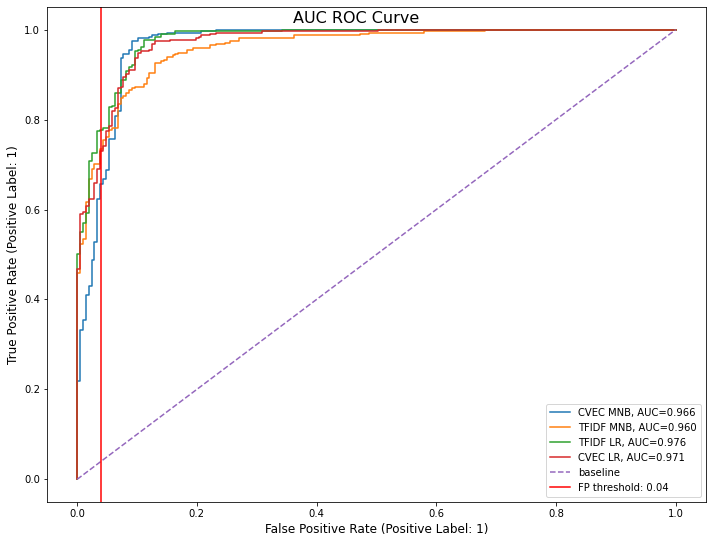

In [110]:
# overlapping ROC curves for all models
#set up plotting area
plt.figure(figsize=(10, 8)).clf()
#pipe_cm: CountVectorizer and Multinomial Naive Bayes
y_pred1 = gs_m1.predict_proba(X_test)[:, 1]
fpr1, tpr1, _ = roc_curve(y_test, y_pred1)
auc1 = round(roc_auc_score(y_test, y_pred1), 4)
plt.plot(fpr1,tpr1,label="CVEC MNB, AUC="+str("{:.3f}".format(auc1)))

#pipe_cl: CountVectorizer and Logistic Regression
y_pred2 = gs_m2.predict_proba(X_test)[:, 1]
fpr2, tpr2, _ = roc_curve(y_test, y_pred2)
auc2 = round(roc_auc_score(y_test, y_pred2), 4)
plt.plot(fpr2,tpr2,label="TFIDF MNB, AUC="+str("{:.3f}".format(auc2)))

#pipe_tm: TF-IDF and Multinomial Naive Bayes
y_pred3 = gs_m3.predict_proba(X_test)[:, 1]
fpr3, tpr3, _ = roc_curve(y_test, y_pred3)
auc3 = round(roc_auc_score(y_test, y_pred3), 4)
plt.plot(fpr3,tpr3,label="TFIDF LR, AUC="+str("{:.3f}".format(auc3)))

#pipe_tl: TF-IDF and Logistic Regression
y_pred4 = gs_m4.predict_proba(X_test)[:, 1]
fpr4, tpr4, _ = roc_curve(y_test, y_pred4)
auc4 = round(roc_auc_score(y_test, y_pred4), 4)
plt.plot(fpr4,tpr4,label="CVEC LR, AUC="+str("{:.3f}".format(auc4)))

plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.suptitle('AUC ROC Curve', fontsize=16,y=0.93)
plt.xlabel('False Positive Rate (Positive Label: 1)', fontsize=12)
plt.ylabel('True Positive Rate (Positive Label: 1)', fontsize=12)
plt.axvline(x=0.04,c='r',label='FP threshold: 0.04')
plt.legend()

plt.tight_layout()
#plt.savefig('auc_roc.png')

All the models exhibited relatively good AUC ROC scores (above 95%). In terms of crossing the chosen False Positive threshold of 0.04, the **CountVectorizer + Multinomial Naive Bayes** pipe was the first to cross the threshold (lowest True Positive Rate), while the **TF-IDF + Logistic Regression** was the last (highest True Positive Rate) to cross the threshold. The **TF-IDF + Logistic Regression** pipe had the highest ROC AUC (0.971), though only marginally higher than the rest. The AUC ROC for our chosen combination, **TF-IDF + Multinomial Naive Bayes**, is the lowest, but comparable with the performance of other models, with the largest and lowest ROC AUC values only differing by 0.02. 

## Predictor words for chosen model (TF-IDF + Multinomial Naive Bayes)

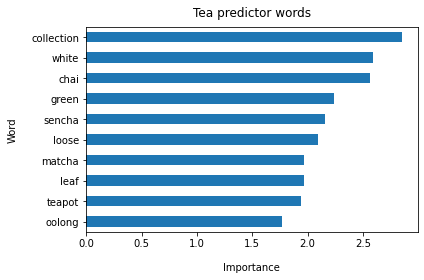

In [105]:
#df_tea.sort_values(by = 'log prob diff').plot(kind = 'barh')
plt.xlabel("Importance", labelpad=14)
plt.ylabel("Word", labelpad=14)
plt.title("Tea predictor words", y=1.02);
#plt.set_yticklabels(ylabel = 'feature',fontdict=None,labelpad=None)
ax = df_tea.sort_values(by = 'log prob diff')['log prob diff'].plot(yticks=df_tea.index, kind='barh')
ax.set_yticklabels(df_tea['feature'])
plt.tight_layout()
#plt.savefig('tea_words.png')

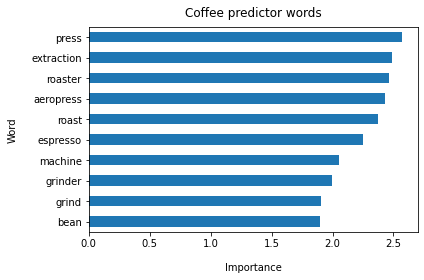

In [106]:
#coffee
#df_tea.sort_values(by = 'log prob diff').plot(kind = 'barh')
plt.xlabel("Importance", labelpad=14)
plt.ylabel("Word", labelpad=14)
plt.title("Coffee predictor words", y=1.02);
#plt.set_yticklabels(ylabel = 'feature',fontdict=None,labelpad=None)
ax = df_coffee.sort_values(by = 'log prob diff', ascending = False)['log prob diff'].apply(lambda x: abs(x)).plot(yticks=df_tea.index, kind='barh')
ax.set_yticklabels(df_coffee['feature'])
plt.tight_layout()
#plt.savefig('coffee_words.png')

**Predictor word importance** - One way to interpret the predictor word plots, is that a post containing a predictor word that falls within a category, is more likely to be from that category, up to the number of times indicated in their importance , holding all else constant. Note that the unit of 'Importance' in log product, so it needs to be exponentiated to get the exact number.

**Difference in category of predictor words** - Predictor words for tea tend to describe variety and quality of tea, while the words for coffee tend to be related to equipment and technology involved in making coffee. This could also be a contributor for the higher performance for our Naive Bayes models.

## Conclusion

The key findings can be summarised as follow:
1. **Chosen model is `TF-IDF + Multinomial Naive Bayes`** The model had the highest accuracy score of 0.931 based on the test score. The model also exhbited high AUC ROC and good classification metric values, well above our baseline accuracy of 0.602 which was simply based on which subreddit the majority of posts came from.
2. **Good performance from all models** - All 4 modeling pipes produced relatively high accuracy scores (lowest 0.896, highest 0.931) and AUC ROC (lowest 0.96, highest 0.976) within a tight range, with similarly good classification metrics. 
3. **Naive Bayes outperforms Logistic Regression** - The two models with Naive Bayes classifiers had higher accuracy scores than the Logistic Regression models. This is likely due to the mutually exclusive nature of tea and coffee drinkers, which increases the independence of the variables and hence effectiveness of Naive Bayes models.
4. **Distinct difference in top predictor words for each subreddit** - Top predictor words for tea tend to describe variety and quality of tea, while the words for coffee tend to be about equipment and technology involved in making coffee.


## Limitations and Future Directions

1. While this study explored how word counts in title and self text differed between r/tea and r/Coffee posts, the word counts were not used in the modeling. This variable could be considered for future models.
2. There are many other features in a Reddit post which could be important in classification, such as date of post, author and the various tags. 
3. The data for this study came exclusively from Reddit. There could be some bias in the types of users and posts. Expanding data collection to more sources, such as other social media and news platforms, could make the model more robust.
4. Expanding the model to be classify multiple categories as F&B businesses and the customer engagement received likely goes beyond just coffee and tea.